# 决策树与随机森林
我之前应该写过决策树，不过好像没有在博客上发过。(https://github.com/xiuzheDorothy/DL_exercise/tree/master/DecisionTree )

前文详细介绍了一个简单的分类器（朴素贝叶斯分类器），以及一个强大的判别分类器（支持向量机）。下面将介绍另一种强大的算法——无参数算法**随机森林**。随机森林是一种集成方法，通过集成多个比较简单的评估器形成累积效果。这种集成方法的学习效果经常出人意料，往往能超过各个组成部分的总和；也就是说，若干评估器的多数投票（majority vote）的最终效果往往优于单个评估器投票的效果。

In [1]:
 %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 随机森林的诱因： 决策树
随机森林是建立在决策树基础上的集成学习器。我们知道，决策树的难点在于如何设计每一步的问题。在实现决策树的机器学习算法中，问题通常因分类边界是与特征轴平行 的形式分割数据而造成的；也就是说，决策树的每个节点都根据一个特征的阈值将数据分成两组。
### 创建一棵决策树
如果想在 Scikit-Learn 中使用决策树拟合数据，可以用 DecisionTreeClassifier 评估器：

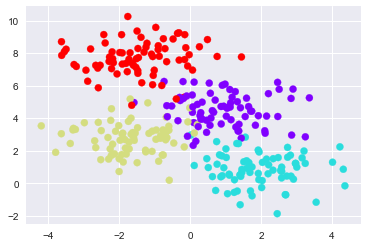

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X,y)

快速写一个辅助函数，对分类器的结果进行可视化：

In [3]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax=ax or plt.gca()
    
    # 画出训练数据
    ax.scatter(X[:,0],X[:,1],c=y,s=30,cmap=cmap,
              clim=(y.min(),y.max()),zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 拟合数据
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
    np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # 为结果生成彩色图
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                        levels=np.arange(n_classes + 1) - 0.5,
                        cmap=cmap, clim=(y.min(), y.max()),
                        zorder=1)
    
    ax.set(xlim=xlim, ylim=ylim)

E:\anaconda\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


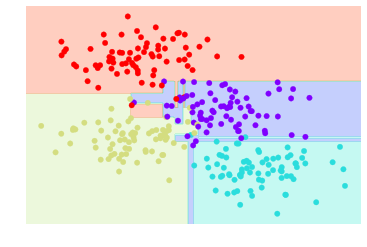

In [4]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [5]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

### 决策树训练和可视化

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
X = iris.data 
y = iris.target
#tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

要将决策树可视化，首先，使用export_graphviz（）方法输出一个图形定义文件，命名为`iris_tree.dot：`

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(
tree_clf,
out_file="iris_tree.dot",
feature_names=iris.feature_names,
class_names=iris.target_names,
rounded=True,
filled=True
)

In [8]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

然后，可以使用graphviz包[1]中的dot命令行工具将这个.dot文件转换为其他格式，例如PDF或PNG。下面这行命令将.dot文件转换为.png图像文件：

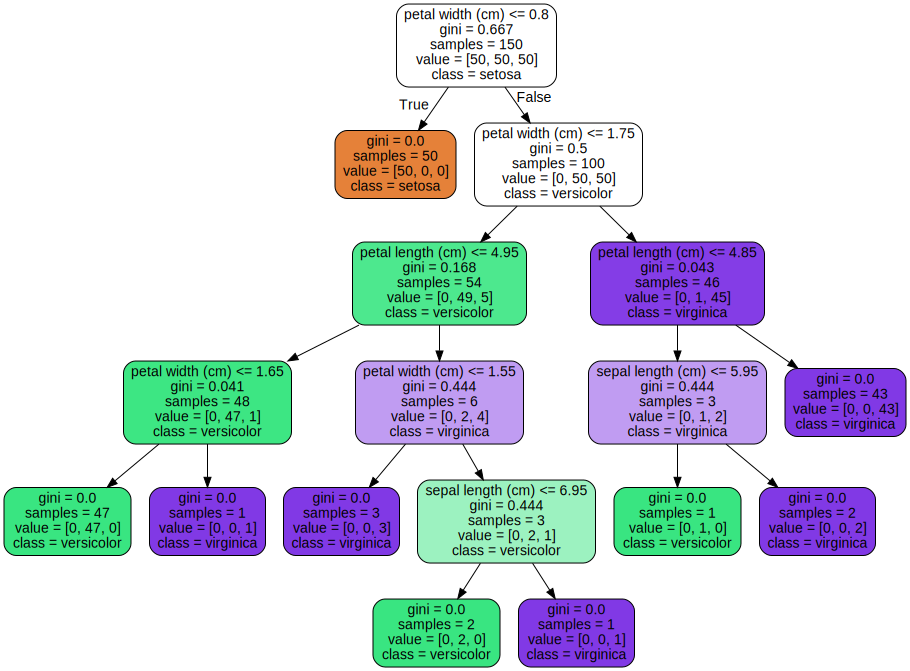

In [9]:
import graphviz
with open("E:\code_studying\DL_exercise\MachineLearning\sklearn\iris_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 决策树与过拟合
当我们训练两棵不同的决策树时，会发现显然，在一些区域，两棵树产生了一致的结果；而在另一些区域，两棵树的分类结果差异很大。不一致往往都发生在分类比较模糊的地方，因此假如将两棵树的结果组合起来，可能就会获得更好的结果，这就是随机森林的来源。
## 评估器集成算法： 随机森林
通过组合多个过拟合评估器来降低过拟合程度的想法其实是一种集成学习方法，称为装袋算法。装袋算法使用并行评估器对数据进行有放回抽取集成（也可以说是大杂烩），每个评估器都对数据过拟合，通过求均值可以获得更好的分类结果。随机决策树的集成算法就是**随机森林**。

我们可以用 Scikit-Learn 的`BaggingClassifier`元评估器来实现这种装袋分类器：

ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 2.

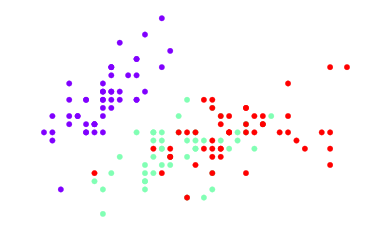

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)
# 100个估计器，每个估计器拟合样本80%的随机数
visualize_classifier(bag, X, y)

其实，如果我们用随机方法（stochasticity）确定数据的分割方式，决策树拟合的随机性会更有效；这样做可以让所有数据在每次训练时都被拟合，但拟合的结果却仍然是随机的。例如，当需要确定对哪个特征进行分割时，随机树可能会从最前面的几个特征中挑选。

在 Scikit-Learn 里对随机决策树集成算法的优化是通过`RandomForestClassifier`评估器实现的，它会自动进行随机化决策,只要选择一组评估器，它们就可以非常快速地完成（如果需要可以并行计算）每棵树的拟合任务:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100,random_state=0)
visualize_classifier(model,X,y)

## 随机森林回归
前面介绍了随机森林分类的内容。其实随机森林也可以用作回归（处理连续变量，而不是离散变量）。随机森林回归的评估器是 RandomForestRegressor，其语法与我们之前看到的非常类似。

<ErrorbarContainer object of 3 artists>

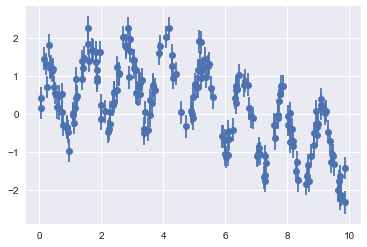

In [29]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)
def model(x,sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')
#plt.scatter(x,y)

通过随机森林回归器，可以获得下面的最佳拟合曲线:

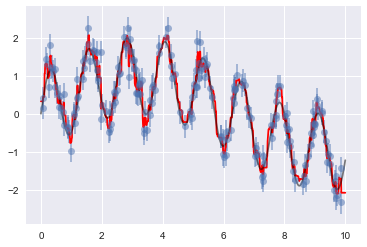

In [30]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

真实模型是平滑曲线，而随机森林模型是**锯齿线**。从图中可以看出，无参数的随机森林模型非常适合处理多周期数据，不需要我们配置多周期模型

既然随机森林模型是锯齿线，还是不建议用作线性回归

## 用随机森林识别手写数字
略

In [59]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)
y=0.5*x+rng.randn(len(x))
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook() #导入这个命令之后bokeh的绘画内容都在notebook上显示
p1=figure(plot_width=600, plot_height=400)
p1.circle(x,y,size=10,line_color=None, fill_color="red", fill_alpha=0.5)
show(p1)

Loading BokehJS ...

In [62]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=4)
tree_reg.fit(x[:,None], y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [63]:
xfit=np.arange(0,10,0.1)
ypre=tree_reg.predict(xfit[:,None])

In [64]:
np.arange(0,10,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [65]:
p1.line(xfit,ypre)
show(p1)

CandidateSet = \{node1,node2,node3,...\}